In [3]:
import win32com.client
import time
import pandas as pd
import numpy as np
import time
from glob import glob

In [2]:
# Build 38 and 200 kHz
filesets = [sorted(glob('E:\\MooredEchosounders\\data\\2018\\EVFiles\\DAFT1\\*.EV')),
            sorted(glob('E:\\MooredEchosounders\\data\\2018\\EVFiles\\DAFT2\\*.EV')),
            sorted(glob('E:\\MooredEchosounders\\data\\2019\\EVFiles\\DAFT1\\*.EV')),
            sorted(glob('E:\\MooredEchosounders\\data\\2019\\EVFiles\\DAFT2\\*.EV')),
            sorted(glob('E:\\MooredEchosounders\\data\\2019\\EVFiles\\DAFT3\\*.EV'))]
line200 = [45.65, 42.9, 45.65, 42.9, 47.5] # range 1.5
line38 = [43.65, 39.8, 42.15, 40.4, 43] # range 3.5 or below ringdown if shallower

for i in range(5):
    print('Working on fileset '+str(i))
    files = filesets[i]
    EvApp = win32com.client.Dispatch("EchoviewCom.EvApplication")
    ct = 0
    for file in files:
        start = time.time()
        EvFile = EvApp.OpenFile(file)
        EvFileSet = EvFile.FileSets.FindByName('Fileset1') # replace with params value
        EvFileSet.SetCalibrationFile('E:\\MooredEchosounders\\data\\EVTemplates\\wbatEmptyCal.ecs')

        EvFile.Import('E:\\MooredEchosounders\\data\\EVTemplates\\WBAT_SawadaCorrection.EV')
        VarParent1 = EvFile.Variables.FindByName("38 kHz Sv in cell")
        VarChild1 = EvFile.Variables.FindByName("Nv threshold bitmap")
        VarNew = EvFile.Variables.FindByName("Fish per volume in cell corr")
        VarNew.SetOperand(1, VarParent1)
        VarChild1.SetOperand(1, VarNew)

        EvVar = EvFile.Transducers.FindByName('Fileset 1: T1 (channel 2)')
        EvVar.BeamRotation = 180
        EvVar.Elevation = 180

        EvVar = EvFile.Transducers.FindByName('Fileset 1: T1 (channel 3)')
        EvVar.BeamRotation = 180
        EvVar.Elevation = 180

        EvNewLine = EvFile.Lines.CreateFixedDepth(line200[i])
        EvNewLine.Name = 'transducerExclusionLine200'

        EvNewLine = EvFile.Lines.CreateFixedDepth(line38[i])
        EvNewLine.Name = 'transducerExclusionLine38'
        EvFile.Save()
        EvFile.Close()
        print('File Saved. Total time: ' + str(int(np.floor((time.time()-start)/60)))+'m '+str(round((time.time()-start)%60))+ 's')
        ct+=1
    EvApp.Quit()

Working on fileset 0
File Saved. Total time: 0m 5s


In [5]:
def evExporterMooringMod(evFiles,year,daft,depth,calFile): # where evFiles is a list of *.EV files (with complete path)
    print(year,' ',daft)
    channels = {70:'channel 1',38:'channel 2',200:'channel 3'}
    newFiles = []
    EvApp = win32com.client.Dispatch("EchoviewCom.EvApplication")
    EvApp.Minimize()
    for file in evFiles:
        start = time.time()
        EvFile = EvApp.OpenFile(file)

        EvFileSet = EvFile.FileSets.FindByName('Fileset1') # replace with params value
        EvFileSet.SetCalibrationFile(calFile)

        for freq in [70,38,200]:
            EvVar = EvFile.Variables.FindByName('Fileset 1: Sv pings T1 ('+channels[freq]+')')
            EvUpperLine = EvFile.Lines.FindByName('surfaceExclusionLine70');
            EvLowerLine = EvFile.Lines.FindByName('transducerExclusionLine'+str(freq));
            regionName = 'WaterColumn_'+str(freq)
            Region1 = EvVar.CreateLineRelativeRegion(regionName,EvUpperLine,EvLowerLine);
            RegClassObj = EvFile.RegionClasses.FindByName('WaterColumn');
            EvFile.Regions.FindByName(regionName).RegionClass = RegClassObj;
            EvFile.Regions.FindByName(regionName).RegionType = 1# 1 is for anlysis

            EvVar.Properties.Data.ApplyMinimumThreshold= 0;
            EvVar.Properties.Data.MinimumThreshold= -70;
            EvVar.Properties.Data.ApplyMaximumThreshold= 0;
            EvVar.Properties.Data.MaximumThreshold=-30;

            #  set grid settings for range in m and distance in nmi as defined by VL
            EvVar.Properties.Grid.SetDepthRangeGrid(1,depth)
            EvVar.Properties.Grid.SetTimeDistanceGrid(1, 60)# 1 is for time, 3 is for nmi

            # set exclusion lines
            EvVar.Properties.Analysis.ExcludeAboveLine = 'surfaceExclusionLine70'
            EvVar.Properties.Analysis.ExcludeBelowLine = 'transducerExclusionLine'+str(freq)

            ExportFileName='E:\\MooredEchosounders\\data\\'+year+'\\EVFiles\\'+daft+'\\exports2\\'+str(freq)+'kHz-'+daft + '-'+\
                                 str(depth)+'m'+'-'+file[-20:-12]+'-'+file[-11:-3]+'.csv'
            exporttest = EvVar.ExportIntegrationByRegionsByCellsAll(ExportFileName);
            if exporttest:
                print('File '+str(freq)+' Exported. Total time: ' + str(int(np.floor((time.time()-start)/60)))+'m '+str(round((time.time()-start)%60))+ 's')
                newFiles.append('E:\\MooredEchosounders\\data\\'+year+'\\EVFiles\\'+daft+'\\exports2\\'+str(freq)+'kHz-'+daft + '-'+\
                                 str(depth)+'m'+'-'+file[-20:-12]+'-'+file[-11:-3]+'.csv')
            else:
                print('File Export Failed')

        EvFile.Close()
    EvApp.Quit()
    print('Done')
    return newFiles

In [106]:
def evExporterMooringTracks(evFiles,year,daft): # where evFiles is a list of *.EV files (with complete path)
    print(year,' ',daft)
    trackExportItems = ['Direction_horizontal','Direction_vertical','Distance_2D_unsmoothed','Distance_3D_unsmoothed','Fish_track_change_in_depth','Fish_track_change_in_range',
        'Speed_2D_max_unsmoothed','Speed_2D_mean_unsmoothed','Speed_4D_max_unsmoothed','Speed_4D_mean_unsmoothed','Time_in_beam','Tortuosity_2D','Tortuosity_3D',
        'Num_targets','Target_depth_max','Target_depth_mean','Target_depth_min','Target_length_mean','Target_range_max','Target_range_mean','Target_range_min',
        'TS_max','TS_mean','TS_min']
    newFiles = []
    EvApp = win32com.client.Dispatch("EchoviewCom.EvApplication")
    EvApp.Minimize()
    for file in evFiles:
        start = time.time()
        EvFile = EvApp.OpenFile(file)        
        FTProps = EvFile.Properties.FishTracking
        FTProps.DataDimensions = 4
        FTProps.Alpha.MajorAxis = 0.6
        FTProps.Alpha.MinorAxis = 0.6
        FTProps.Alpha.Range = 0.6
        FTProps.Beta.MajorAxis = 0.0
        FTProps.Beta.MinorAxis = 0.0
        FTProps.Beta.Range = 0.0
        FTProps.ExclusionDistance.MajorAxis = 0.7
        FTProps.ExclusionDistance.MinorAxis = 0.7
        FTProps.ExclusionDistance.Range = 0.3
        FTProps.MissedPingExpansion.MajorAxis = 10
        FTProps.MissedPingExpansion.MinorAxis = 10
        FTProps.MissedPingExpansion.Range = 10

        FTProps.Weights.MajorAxis = 30
        FTProps.Weights.MinorAxis = 30
        FTProps.Weights.Range = 30
        FTProps.Weights.TS = 30
        FTProps.Weights.PingGap = 10

        FTProps.MinimumTargets = 5
        FTProps.MinimumPings = 5
        FTProps.MaximumGap = 5

        EvFileSet = EvFile.FileSets.FindByName('Fileset1') # replace with params value
        EvFileSet.SetCalibrationFile('E:\\MooredEchosounders\\data\\EVTemplates\\wbatEmptyCal.ecs')
        EvVar = EvFile.Variables.FindByName('38 kHz single targets')  #'38 kHz Nv filtered single targets' for sawada, actually 70 kHz
        EvVar.Properties.Analysis.ExcludeAboveLine = 'surfaceExclusionLine70'
        EvVar.Properties.Analysis.ExcludeBelowLine = 'transducerExclusionLine70'
        EvVar.DetectFishTracks('fishTracks');
        EvFile.Properties.Export.Mode=1

        for item in trackExportItems:
            EvFile.Properties.Export.Variables.Item(item).Enabled=1
        EvFile.Properties.Export
        exporttest = EvVar.ExportFishTracksByRegionsAll('E:\\MooredEchosounders\\data\\'+year+'\\EVFiles\\'+daft+'\\exports\\FishTracks4D-'+daft + '-'+\
                                '5m'+'-'+file[-20:-12]+'-'+file[-11:-3]+'.csv')
        if exporttest:
            print('File Exported. Total time: ' + str(int(np.floor((time.time()-start)/60)))+'m '+str(round((time.time()-start)%60))+ 's')
            newFiles.append('E:\\MooredEchosounders\\data\\'+year+'\\EVFiles\\'+daft+'\\exports\\FishTracks4D-'+daft + '-'+\
                                '5m'+'-'+file[-20:-12]+'-'+file[-11:-3]+'.csv')
        EvFile.Close()
    EvApp.Quit()
    print('Done')
    return newFiles

In [6]:
filesets = [sorted(glob('E:\\MooredEchosounders\\data\\2018\\EVFiles\\DAFT1\\*.EV')),
            sorted(glob('E:\\MooredEchosounders\\data\\2018\\EVFiles\\DAFT2\\*.EV')),
            sorted(glob('E:\\MooredEchosounders\\data\\2019\\EVFiles\\DAFT1\\*.EV')),
            sorted(glob('E:\\MooredEchosounders\\data\\2019\\EVFiles\\DAFT2\\*.EV')),
            sorted(glob('E:\\MooredEchosounders\\data\\2019\\EVFiles\\DAFT3\\*.EV'))]

year = '2018'
daft = 'DAFT1'
depth = 1
a = evExporterMooringMod(filesets[0],year,daft,depth,'E:\\MooredEchosounders\\data\\Calibrations\\FinalCalData\\C11_17_18.ecs')

2018   DAFT1
File 70 Exported. Total time: 0m 7s
File 38 Exported. Total time: 0m 10s
File 200 Exported. Total time: 0m 13s
File 70 Exported. Total time: 0m 7s
File 38 Exported. Total time: 0m 10s
File 200 Exported. Total time: 0m 13s
File 70 Exported. Total time: 0m 8s
File 38 Exported. Total time: 0m 10s
File 200 Exported. Total time: 0m 13s
File 70 Exported. Total time: 0m 8s
File 38 Exported. Total time: 0m 10s
File 200 Exported. Total time: 0m 13s
File 70 Exported. Total time: 0m 8s
File 38 Exported. Total time: 0m 10s
File 200 Exported. Total time: 0m 14s
File 70 Exported. Total time: 0m 8s
File 38 Exported. Total time: 0m 10s
File 200 Exported. Total time: 0m 13s
File 70 Exported. Total time: 0m 7s
File 38 Exported. Total time: 0m 10s
File 200 Exported. Total time: 0m 13s
File 70 Exported. Total time: 0m 8s
File 38 Exported. Total time: 0m 11s
File 200 Exported. Total time: 0m 14s
File 70 Exported. Total time: 0m 8s
File 38 Exported. Total time: 0m 10s
File 200 Exported. Total t

In [ ]:
filesets = [sorted(glob('E:\\MooredEchosounders\\data\\2018\\EVFiles\\DAFT1\\*.EV')),
            sorted(glob('E:\\MooredEchosounders\\data\\2018\\EVFiles\\DAFT2\\*.EV')),
            sorted(glob('E:\\MooredEchosounders\\data\\2019\\EVFiles\\DAFT1\\*.EV')),
            sorted(glob('E:\\MooredEchosounders\\data\\2019\\EVFiles\\DAFT2\\*.EV')),
            sorted(glob('E:\\MooredEchosounders\\data\\2019\\EVFiles\\DAFT3\\*.EV'))]

year = '2018'
daft = 'DAFT1'
depth = 1
a = evExporterMooringMod(filesets[0],year,daft,depth)
year = '2018'
daft = 'DAFT2'
a = evExporterMooringMod(filesets[1],year,daft,depth)
year = '2019'
daft = 'DAFT1'
a = evExporterMooringMod(filesets[2],year,daft,depth)
year = '2019'
daft = 'DAFT2'
a = evExporterMooringMod(filesets[3],year,daft,depth)
year = '2019'
daft = 'DAFT3'
a = evExporterMooringMod(filesets[4],year,daft,depth)

In [ ]:
filesets = [sorted(glob('E:\\MooredEchosounders\\data\\2018\\EVFiles\\DAFT1\\*.EV')),
            sorted(glob('E:\\MooredEchosounders\\data\\2018\\EVFiles\\DAFT2\\*.EV')),
            sorted(glob('E:\\MooredEchosounders\\data\\2019\\EVFiles\\DAFT1\\*.EV')),
            sorted(glob('E:\\MooredEchosounders\\data\\2019\\EVFiles\\DAFT2\\*.EV')),
            sorted(glob('E:\\MooredEchosounders\\data\\2019\\EVFiles\\DAFT3\\*.EV'))]

year = '2018'
daft = 'DAFT1'
a = evExporterMooringMod(filesets[0],year,daft)
year = '2018'
daft = 'DAFT2'
a = evExporterMooringMod(filesets[1],year,daft)
year = '2019'
daft = 'DAFT1'
a = evExporterMooringMod(filesets[2],year,daft)
year = '2019'
daft = 'DAFT2'
a = evExporterMooringMod(filesets[3],year,daft)
year = '2019'
daft = 'DAFT3'
a = evExporterMooringMod(filesets[4],year,daft)

year = '2018'
daft = 'DAFT1'
a = evExporterMooringTracks(filesets[0],year,daft)
year = '2018'
daft = 'DAFT2'
a = evExporterMooringTracks(filesets[1],year,daft)
year = '2019'
daft = 'DAFT1'
a = evExporterMooringTracks(filesets[2],year,daft)
year = '2019'
daft = 'DAFT2'
a = evExporterMooringTracks(filesets[3],year,daft)
year = '2019'
daft = 'DAFT3'
a = evExporterMooringTracks(filesets[4],year,daft)

In [14]:
import pandas as pd
from glob import glob
import numpy as np
import matplotlib.dates as mdates
from evFileProcessing import evFuncs # ev COM functions
import matplotlib.pyplot as plt

def daftPivot(daft):
    dfD1_70 = evFuncs.evExports.readEvExports(sorted(glob('E:/MooredEchosounders/data/2018/EVFiles/'+daft+'/exports/1m/70*.csv'))+sorted(glob('E:/MooredEchosounders/data/2019/EVFiles/'+daft+'/exports/1m/70*.csv')))
    dfD1_38 = evFuncs.evExports.readEvExports(sorted(glob('E:/MooredEchosounders/data/2018/EVFiles/'+daft+'/exports/1m/38*.csv'))+sorted(glob('E:/MooredEchosounders/data/2019/EVFiles/'+daft+'/exports/1m/38*.csv')))
    dfD1_200 = evFuncs.evExports.readEvExports(sorted(glob('E:/MooredEchosounders/data/2018/EVFiles/'+daft+'/exports/1m/200*.csv'))+sorted(glob('E:/MooredEchosounders/data/2019/EVFiles/'+daft+'/exports/1m/200*.csv')))
    dfD1_70['wakeup'] = pd.to_datetime(dfD1_70.index.map(lambda x: x.strftime('%Y-%m-%d %H')))
    dfD1_38['wakeup'] = pd.to_datetime(dfD1_38.index.map(lambda x: x.strftime('%Y-%m-%d %H')))
    dfD1_200['wakeup'] = pd.to_datetime(dfD1_200.index.map(lambda x: x.strftime('%Y-%m-%d %H')))
    
    dfD1_200.loc[(dfD1_200.datetime>pd.to_datetime('2018-08-15 00:00:00'))&(dfD1_200.layer.isin([16,17,18,19,20,27,28,29,30]))&(dfD1_200.Sv <-68),'Sv']=np.nan

    piv70 = pd.pivot_table(dfD1_70, values="Sv",index=["layer"], columns=["wakeup"], fill_value=np.nan)
    piv38 = pd.pivot_table(dfD1_38, values="Sv",index=["layer"], columns=["wakeup"], fill_value=np.nan)
    piv200 = pd.pivot_table(dfD1_200, values="Sv",index=["layer"], columns=["wakeup"], fill_value=np.nan)
    return piv70, piv38, piv200

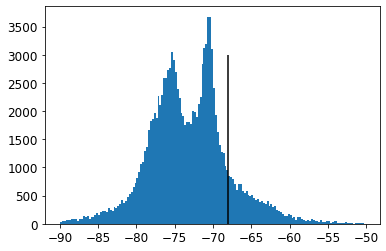

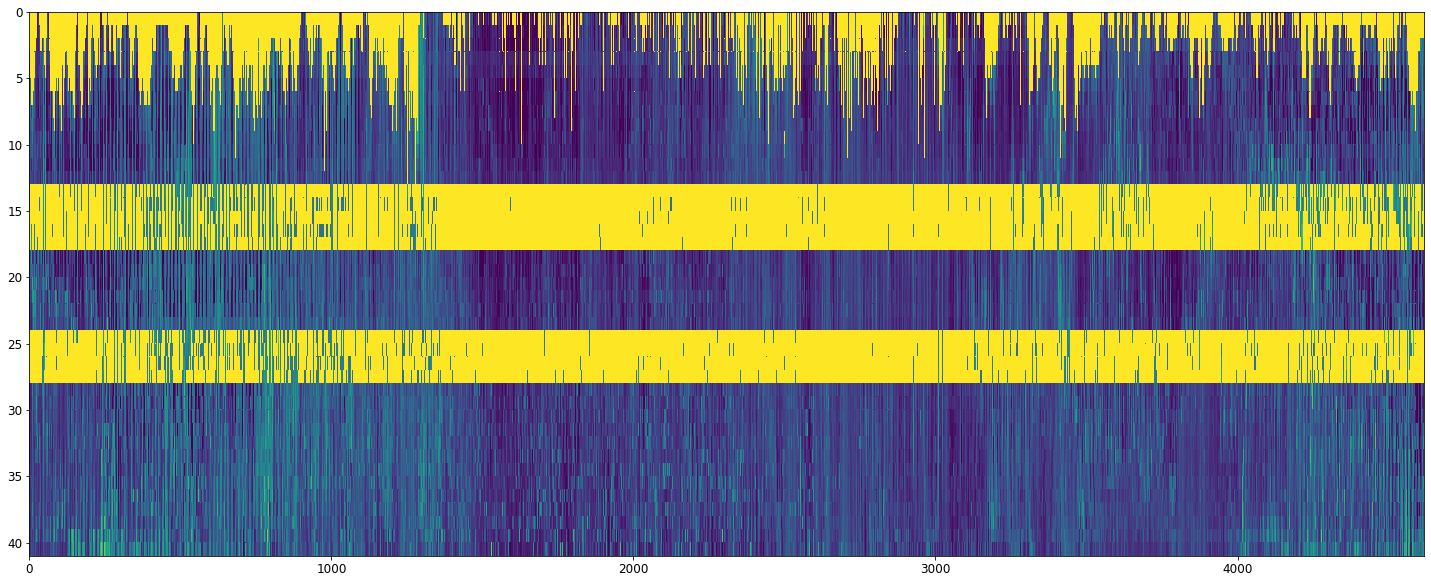

In [34]:
cutoff = -68
dfD1_200 = evFuncs.evExports.readEvExports(sorted(glob('E:/MooredEchosounders/data/2019/EVFiles/DAFT2/exports/1m/200*.csv')))
plt.hist(dfD1_200[(dfD1_200.layer.isin([16,17,18,19,20,27,28,29,30]))].Sv,bins=np.arange(-90,-50,.25));
plt.vlines(cutoff,0,3000,'k')

dfD1_200['wakeup'] = pd.to_datetime(dfD1_200.index.map(lambda x: x.strftime('%Y-%m-%d %H')))
dfD1_200_2 = dfD1_200
dfD1_200_2.loc[(dfD1_200_2.layer.isin([16,17,18,19,20,27,28,29,30]))&(dfD1_200_2.Sv <cutoff),'Sv']=np.nan

a = pd.pivot_table(dfD1_200_2, values="Sv",index=["layer"], columns=["wakeup"], fill_value=0)
fig, ax = plt.subplots(figsize=(25,10))
heatmap = ax.pcolormesh(a, cmap=plt.cm.viridis,vmin=-90, vmax=-30)
ax.invert_yaxis()

Text(0, 0.5, 'Depth (m)')

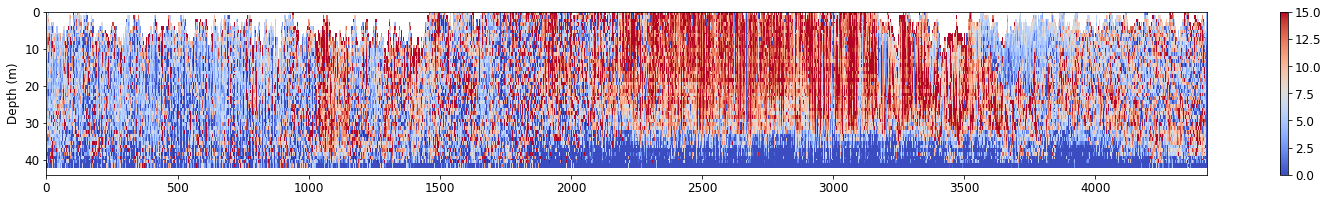

In [19]:
import pandas as pd
from glob import glob
import numpy as np
import matplotlib.dates as mdates
from evFileProcessing import evFuncs # ev COM functions
import matplotlib.pyplot as plt


dfD1_70 = evFuncs.evExports.readEvExports(sorted(glob('E:/MooredEchosounders/data/2018/EVFiles/DAFT1/exports/1m/70*.csv')))
dfD1_702 = evFuncs.evExports.readEvExports(sorted(glob('E:/MooredEchosounders/data/2018/EVFiles/DAFT1/exports2/38*.csv')))
dfD1_70['wakeup'] = pd.to_datetime(dfD1_70.index.map(lambda x: x.strftime('%Y-%m-%d %H')))
dfD1_702['wakeup'] = pd.to_datetime(dfD1_702.index.map(lambda x: x.strftime('%Y-%m-%d %H')))

piv70 = pd.pivot_table(dfD1_70, values="Sv",index=["layer"], columns=["wakeup"], fill_value=np.nan)
piv702 = pd.pivot_table(dfD1_702, values="Sv",index=["layer"], columns=["wakeup"], fill_value=np.nan)

#piv70, piv38, piv200 = daftPivot('DAFT2')
plt.rcParams.update({'font.size':12})
fig, ax = plt.subplots(figsize=(26,3))
heatmap = ax.pcolormesh(piv70-piv702, cmap=plt.cm.coolwarm,vmin=0, vmax=15)
ax.invert_yaxis()
fig.colorbar(heatmap, ax=ax)
plt.ylabel('Depth (m)')

Text(0, 0.5, 'Depth (m)')

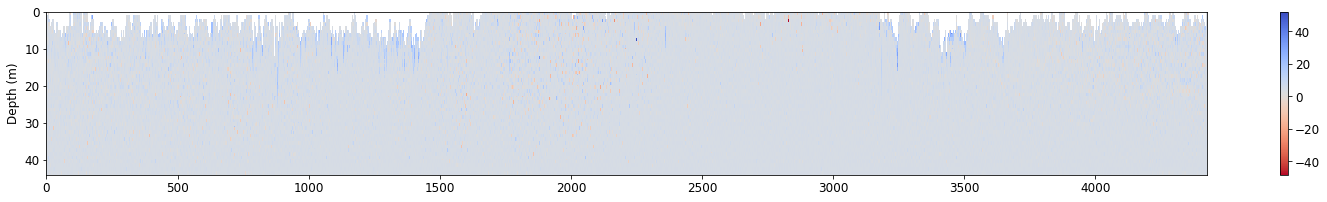

In [12]:
#piv70, piv38, piv200 = daftPivot('DAFT2')
plt.rcParams.update({'font.size':12})
fig, ax = plt.subplots(figsize=(26,3))
heatmap = ax.pcolormesh(piv70-piv702, cmap=plt.cm.coolwarm_r)
ax.invert_yaxis()
fig.colorbar(heatmap, ax=ax)
plt.ylabel('Depth (m)')

Text(0, 0.5, 'Depth (m)')

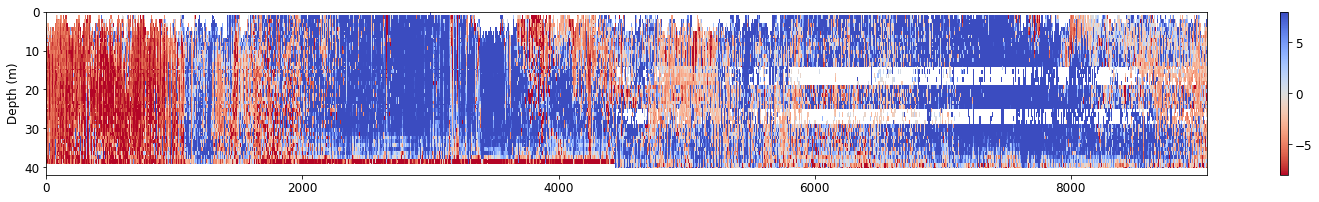

In [37]:
#piv70, piv38, piv200 = daftPivot('DAFT2')
plt.rcParams.update({'font.size':12})
fig, ax = plt.subplots(figsize=(26,3))
heatmap = ax.pcolormesh(piv200-piv38, cmap=plt.cm.coolwarm_r,vmin=-8, vmax=8)
ax.invert_yaxis()
fig.colorbar(heatmap, ax=ax)
plt.ylabel('Depth (m)')

In [ ]:
piv70, piv38, piv200 = daftPivot('DAFT3')
plt.rcParams.update({'font.size':12})
fig, ax = plt.subplots(figsize=(13,3))
heatmap = ax.pcolormesh(piv70-piv70, cmap=plt.cm.coolwarm,vmin=-8, vmax=8)
ax.invert_yaxis()
fig.colorbar(heatmap, ax=ax)
plt.ylabel('Depth (m)')

piv70, piv38, piv200 = daftPivot('DAFT2')
plt.rcParams.update({'font.size':12})
fig, ax = plt.subplots(figsize=(26,3))
heatmap = ax.pcolormesh(piv200-piv70, cmap=plt.cm.coolwarm,vmin=-8, vmax=8)
ax.invert_yaxis()
fig.colorbar(heatmap, ax=ax)
plt.ylabel('Depth (m)')

piv70, piv38, piv200 = daftPivot('DAFT1')
plt.rcParams.update({'font.size':12})
fig, ax = plt.subplots(figsize=(26,3))
heatmap = ax.pcolormesh(piv200-piv70, cmap=plt.cm.coolwarm,vmin=-8, vmax=8)
ax.invert_yaxis()
fig.colorbar(heatmap, ax=ax)
plt.ylabel('Depth (m)')

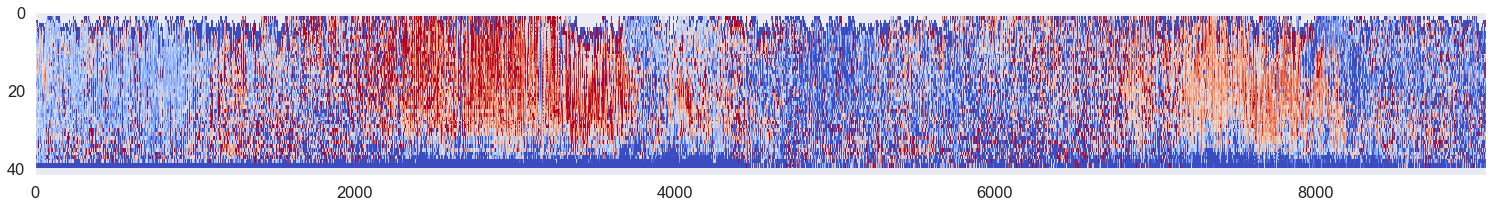

In [235]:
fig, ax = plt.subplots(figsize=(26,3))
heatmap = ax.pcolormesh(piv70-piv38, cmap=plt.cm.coolwarm,vmin=0, vmax=15)
ax.invert_yaxis()

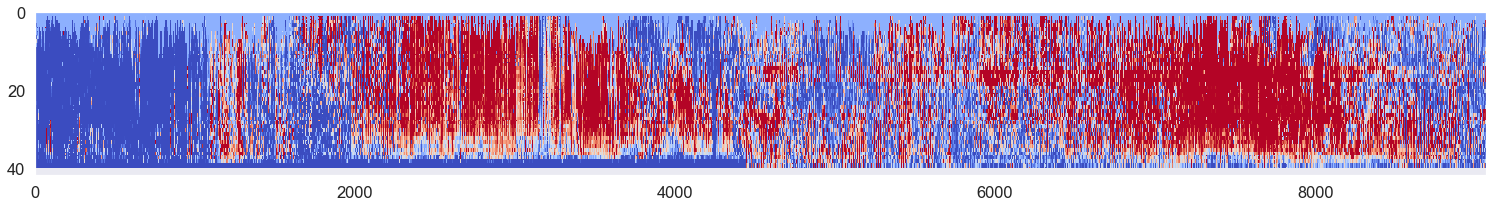

In [213]:
fig, ax = plt.subplots(figsize=(26,3))
heatmap = ax.pcolormesh(piv200-piv38, cmap=plt.cm.coolwarm,vmin=-4, vmax=12)
ax.invert_yaxis()

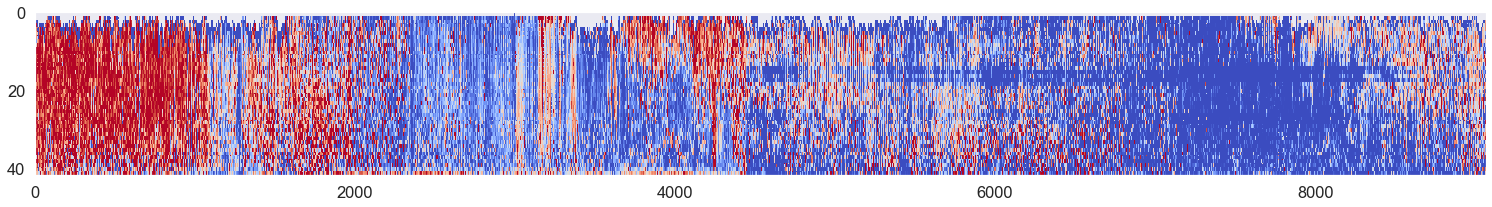

In [243]:
fig, ax = plt.subplots(figsize=(26,3))
heatmap = ax.pcolormesh(piv70-piv200, cmap=plt.cm.coolwarm,vmin=-4, vmax=12)
ax.invert_yaxis()

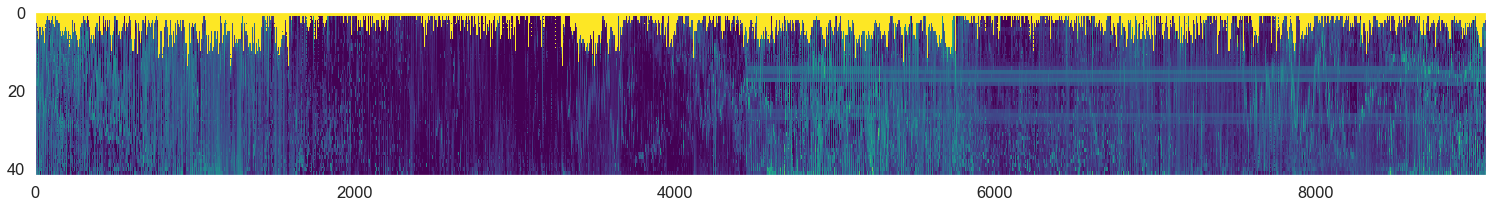

In [236]:
fig, ax = plt.subplots(figsize=(26,3))
#piv[piv==0]
heatmap = ax.pcolormesh(piv200, cmap=plt.cm.viridis,vmin=-90, vmax=-30)
ax.invert_yaxis()